## 297 - Calculating and Plotting Geostrophic and Ageostrophic Wind

[Youtube](https://www.youtube.com/watch?v=rg19Rudo5Ko)

[Geostrophic and Ageostrophic wind](https://www.e-education.psu.edu/meteo361/sites/www.e-education.psu.edu.meteo361/files/Lesson3/jet_streak0105.gif)

In [1]:
from siphon.catalog import TDSCatalog
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p25deg/Best')

In [2]:
best_ds = list(best_gfs.datasets.values())[0]

In [3]:
ncss = best_ds.subset()

In [4]:
query = ncss.query()

In [5]:
ncss.variables

{'Absolute_vorticity_isobaric',
 'Albedo_surface_Mixed_intervals_Average',
 'Apparent_temperature_height_above_ground',
 'Best_4_layer_Lifted_Index_surface',
 'Categorical_Freezing_Rain_surface',
 'Categorical_Freezing_Rain_surface_Mixed_intervals_Average',
 'Categorical_Ice_Pellets_surface',
 'Categorical_Ice_Pellets_surface_Mixed_intervals_Average',
 'Categorical_Rain_surface',
 'Categorical_Rain_surface_Mixed_intervals_Average',
 'Categorical_Snow_surface',
 'Categorical_Snow_surface_Mixed_intervals_Average',
 'Cloud_Work_Function_entire_atmosphere_single_layer_Mixed_intervals_Average',
 'Cloud_mixing_ratio_hybrid',
 'Cloud_mixing_ratio_isobaric',
 'Cloud_water_entire_atmosphere_single_layer',
 'Composite_reflectivity_entire_atmosphere',
 'Convective_Precipitation_Rate_surface_Mixed_intervals_Average',
 'Convective_available_potential_energy_pressure_difference_layer',
 'Convective_available_potential_energy_surface',
 'Convective_inhibition_pressure_difference_layer',
 'Convective_

In [6]:
from datetime import datetime
query.lonlat_box(north = 50, south = 25, east = -75, west = -122).time(datetime.utcnow())
query.accept('netcdf4')
query.variables('u-component_of_wind_isobaric', 'v-component_of_wind_isobaric', 'Geopotential_height_isobaric')

var=u-component_of_wind_isobaric&var=v-component_of_wind_isobaric&var=Geopotential_height_isobaric&time=2023-10-17T21%3A21%3A04.697624&west=-122&east=-75&south=25&north=50&accept=netcdf4

In [7]:
from xarray.backends import NetCDF4DataStore
import xarray as xr

In [8]:
data = ncss.get_data(query)
data = xr.open_dataset(NetCDF4DataStore(data))
list(data)

['u-component_of_wind_isobaric',
 'v-component_of_wind_isobaric',
 'Geopotential_height_isobaric',
 'LatLon_721X1440-0p13S-180p00E-2']

In [9]:
def find_time_var(var, time_basename = 'time'):
	for coord_name in var.coords:
		if coord_name.startswith(time_basename):
			return var.coords[coord_name]
	return ValueError('No time variable found!')

In [10]:
wind_u = data['u-component_of_wind_isobaric']
wind_v = data['v-component_of_wind_isobaric']
heights = data['Geopotential_height_isobaric']
time_1d = find_time_var(wind_u)

In [11]:
from metpy.units import units
import numpy as np
import metpy.calc as mpcalc

In [12]:
lon = wind_u.metpy.longitude
lat = wind_u.metpy.latitude
lon_2d, lat_2d = np.meshgrid(lon, lat)

In [13]:
u_wind = wind_u.sel(isobaric = 50000 * units.Pa).isel(time = 0)
v_wind = wind_v.sel(isobaric = 50000 * units.Pa).isel(time = 0)
height = heights.sel(isobaric = 50000 * units.Pa).isel(time = 0)

In [14]:
geostrophic_u, geostrophic_v = mpcalc.geostrophic_wind(height)

In [15]:
ageostrophic_u = u_wind.values * units('m/s') - geostrophic_u 
ageostrophic_v = v_wind.values * units('m/s') - geostrophic_v

In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

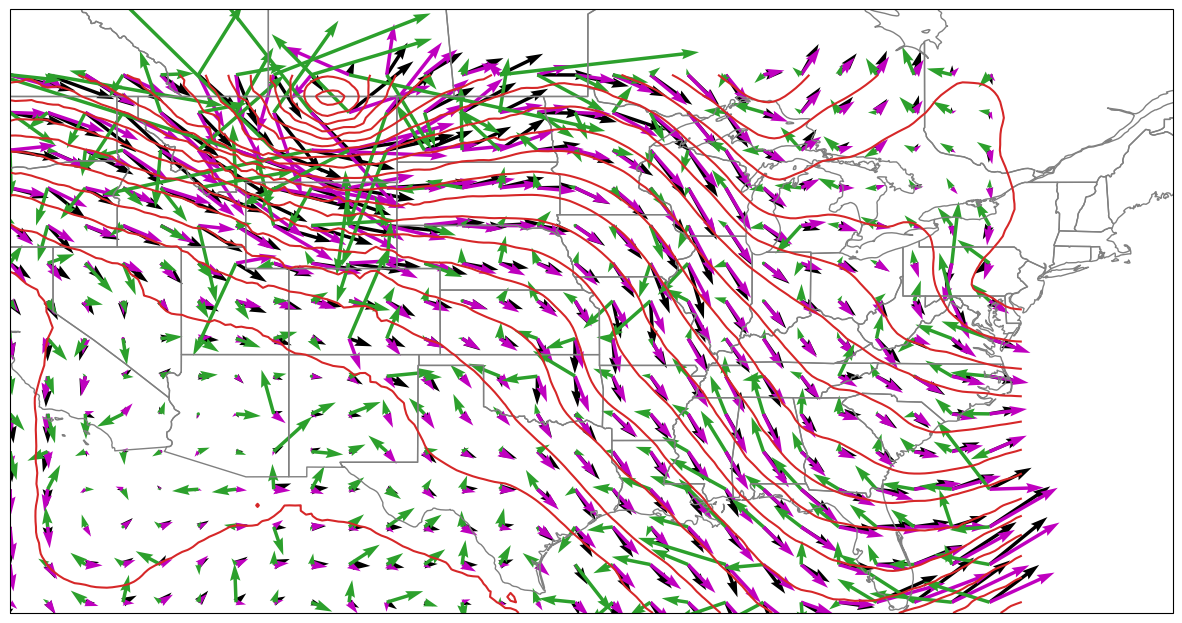

In [17]:
fig = plt.figure(figsize = (15, 12)) 
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([-122, -68, 25, 50])
ax.add_feature(cfeature.STATES, edgecolor = 'gray')

decimate = slice(None, None, 7)
ax.quiver(lon_2d[decimate, decimate], lat_2d[decimate, decimate], u_wind[decimate, decimate], v_wind[decimate, decimate])
ax.quiver(lon_2d[decimate, decimate], lat_2d[decimate, decimate], geostrophic_u[decimate, decimate], geostrophic_v[decimate, decimate], color = 'm')
ax.quiver(lon_2d[decimate, decimate], lat_2d[decimate, decimate], ageostrophic_u[decimate, decimate], ageostrophic_v[decimate, decimate], color = 'tab:green')
ax.contour(lon_2d, lat_2d, height, np.arange(5000, 6000, 20), colors = 'tab:red')